# Import packages

In [1]:
import matplotlib as mpl
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import matplotlib.lines as mlines
import numpy as np
from matplotlib.font_manager import FontProperties
import pygris
import pandas as pd

# Import data

In [2]:
# Set directories
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

# Import the county shapefile
shapefile = gpd.read_file(parent_dir + '/Data Input/DuBoisChallenge - Georgia Counties w 1870 & 1880 data.shp')

# Define target projection (e.g., WGS84)
target_crs = 'EPSG:4326'  # WGS84 projection

# Reproject to the target CRS
shapefile = shapefile.to_crs(target_crs)

In [3]:
# Import the census tracts
ga_tracts = pygris.tracts(state='Georgia')

# Reproject to the target CRS
ga_tracts = ga_tracts.to_crs(target_crs)

Using the default year of 2021
Using FIPS code '13' for input 'Georgia'


In [4]:
# Review the county level data
shapefile.head()

,DECADE,NHGISNAM,NHGISST,NHGISCTY,ICPSRST,ICPSRCTY,ICPSRNAM,STATENAM,ICPSRSTI,ICPSRCTYI,ICPSRFIP,GISJOIN,GISJOIN2,data1870 (,data1880_P,geometry
0,1880,Appling,130,0010,44,10,APPLING,Georgia,44,10,13001.0,G1300010,1300010,> 1000,1000 - 2500,"POLYGON ((-82.04858 31.82707, -82.04877 31.826..."
1,1880,Baker,130,0070,44,70,BAKER,Georgia,44,70,13007.0,G1300070,1300070,2500 - 5000,5000 - 10000,"POLYGON ((-84.50808 31.07840, -84.50808 31.078..."
2,1880,Baldwin,130,0090,44,90,BALDWIN,Georgia,44,90,13009.0,G1300090,1300090,5000 - 10000,5000 - 10000,"POLYGON ((-83.05220 33.08068, -83.05235 33.080..."
3,1880,Banks,130,0110,44,110,BANKS,Georgia,44,110,13011.0,G1300110,1300110,> 1000,1000 - 2500,"POLYGON ((-83.45977 34.48114, -83.45918 34.480..."
4,1880,Bartow,130,0150,44,150,BARTOW,Georgia,44,150,13015.0,G1300150,1300150,2500 - 5000,5000 - 10000,"POLYGON ((-84.65923 34.07800, -84.66166 34.078..."


In [5]:
# Review the census tract data
ga_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,13,221,960204,13221960204,9602.04,Census Tract 9602.04,G5020,S,56805722,528917,+33.9813390,-083.2146320,"POLYGON ((-83.27914 33.95465, -83.27861 33.954..."
1,13,221,960206,13221960206,9602.06,Census Tract 9602.06,G5020,S,126264475,808278,+33.8807034,-083.0448301,"POLYGON ((-83.16114 33.86625, -83.16112 33.866..."
2,13,221,960205,13221960205,9602.05,Census Tract 9602.05,G5020,S,127060640,1390120,+33.9575357,-083.1351227,"POLYGON ((-83.19142 34.01254, -83.19090 34.013..."
3,13,221,960203,13221960203,9602.03,Census Tract 9602.03,G5020,S,111205495,1238620,+33.8940049,-083.2040757,"POLYGON ((-83.27581 33.84828, -83.27551 33.848..."
4,13,153,020900,13153020900,209,Census Tract 209,G5020,S,5106205,8782,+32.6089600,-083.6318937,"POLYGON ((-83.65171 32.61835, -83.64991 32.618..."


In [6]:
# Counts of population ranges in 1870
shapefile["data1870 ("].value_counts()

data1870 (
2500 - 5000      37
5000 - 10000     33
> 1000           32
1000 - 2500      22
10000 - 15000     5
15000 - 20000     2
20000 - 30000     1
Name: count, dtype: int64

In [8]:
# Counts of population ranges in 1880
shapefile["data1880_P"].value_counts()

data1880_P
5000 - 10000     38
2500 - 5000      32
1000 - 2500      26
> 1000           21
10000 - 15000    14
15000 - 20000     3
20000 - 30000     3
Name: count, dtype: int64

# Clean Data

In [14]:
# Rename columns
shapefile.rename(columns={'data1870 (': 'data1870', 'data1880_P': 'data1880'}, inplace=True)

# Relabel NAs with 'None'
shapefile["data1870"] = shapefile["data1870"].fillna('None')
shapefile["data1880"] = shapefile["data1880"].fillna('None')

# Change labels to match labels in the original image
changes = {
    '20000 - 30000': 'BETWEEN 20,000 AND 30,000',
    '15000 - 20000': '15,000 TO 20,000',
    '10000 - 15000': '10,000 TO 15,000',
    '5000 - 10000': '5,000 TO 10,000',
    '2500 - 5000': '2,500 TO 5,000',
    '1000 - 2500': '1,000 TO 2,500',
    '> 1000': 'UNDER 1,000'
}

# Apply new labels to the data columns
shapefile["data1870"] = shapefile["data1870"].replace(changes)
shapefile["data1880"] = shapefile["data1880"].replace(changes)

# Plot data

In [23]:
# Create the Du Bois color palette
duboisPalette = {'BETWEEN 20,000 AND 30,000': '#201E56',
                 '15,000 TO 20,000': '#3e2518',
                 '10,000 TO 15,000': '#D0B49C',
                 '5,000 TO 10,000': '#D62B3F',
                 '2,500 TO 5,000': '#E5A59E',
                 '1,000 TO 2,500': '#f2b438',
                 'UNDER 1,000': '#3e5748',
                 'None': '#e2cebb'
                 }

# Create a color column based on the categories for each data column
shapefile['color1870'] = shapefile['data1870'].map(duboisPalette)
shapefile['color1880'] = shapefile['data1880'].map(duboisPalette)

In [25]:
# Set seed for reproducibility
np.random.seed(20240223)

# Randomly assign numbers for transparency level
ga_tracts['alpha_level'] = np.random.uniform(low=0.01, high=0.2, size=len(ga_tracts))

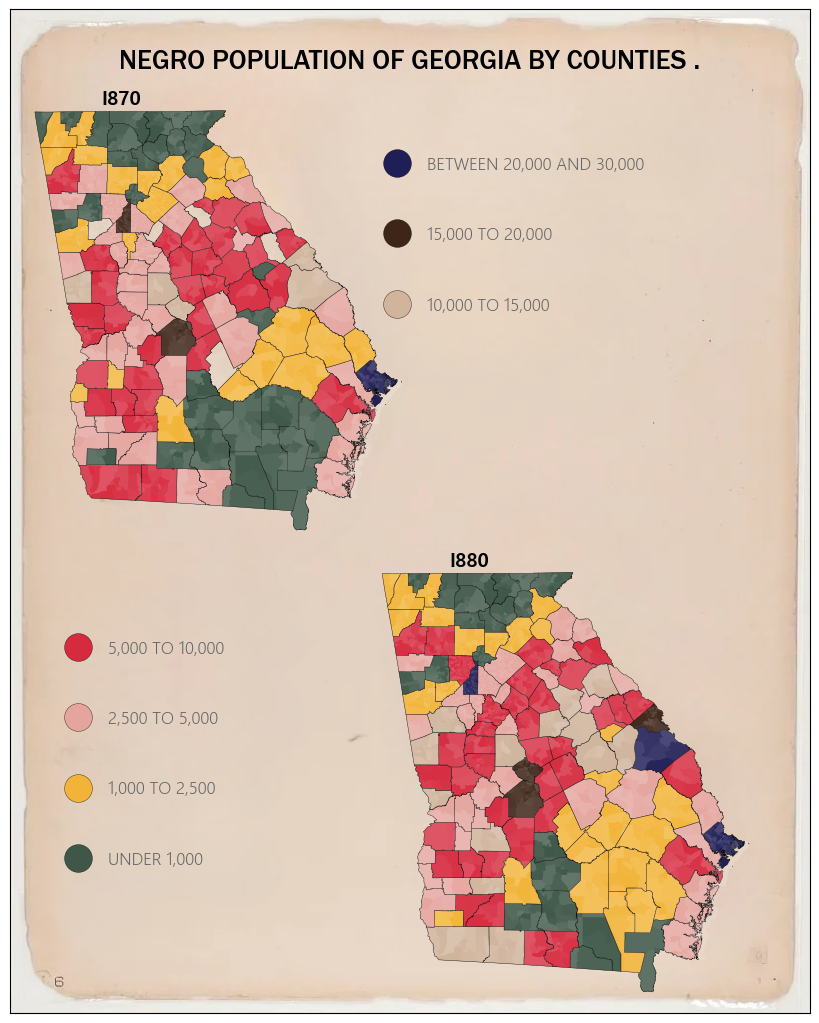

In [26]:
# Read in the background image of the figure
background = plt.imread(parent_dir + '/Data Input/background_photo.jpg')

# Set up the initial figure dimensions
width = 8
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(width, width * background.shape[0] / background.shape[1]))

# Create a dummy subplot for the background
background_ax = plt.axes([0, 0, 1, 1]) 

# Set the background subplot behind the others
background_ax.set_zorder(-1) 

# Show the background image
background_ax.imshow(background, aspect='auto') 

# Plot the county level maps using the Du Bois color palette
shapefile.plot(ax=ax1, color=shapefile['color1870'], legend=True, edgecolor = 'black', linewidth=0.3)
shapefile.plot(ax=ax4, color=shapefile['color1880'], legend=True, edgecolor = 'black', linewidth=0.3)

# Plot the census tract level maps using the randomly assigned transparency levels
ga_tracts.plot(ax=ax1, alpha=ga_tracts['alpha_level'], edgecolor=None, facecolor='white')
ga_tracts.plot(ax=ax4, alpha=ga_tracts['alpha_level'], edgecolor=None, facecolor='white') 

# Turn off the axis marks
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
ax4.set_axis_off()


# Set the font type, size, and weight for the legends
font_legend = FontProperties(family='Malgun Gothic', size=12, weight='ultralight') 

# Create the custom legend by assigning line style, marker size, marker edge color, and marker edge width
handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=20, label=label, markeredgecolor='black', markeredgewidth=0.25) for label, color in duboisPalette.items()]

# Create the top legend 
legend_top_right = handles[0:3]
ax2.legend(handles=legend_top_right, loc=(0.03, 0.50), frameon=False, labelspacing=3.2, prop = font_legend, labelcolor='#666666')

# Create the bottom legend
legend_bottom_left = handles[3:7]
ax3.legend(handles=legend_bottom_left, loc=(0.1, 0.3), frameon=False, labelspacing=3.2, prop = font_legend, labelcolor='#666666')

# Add the title
fig.suptitle('NEGRO POPULATION OF GEORGIA BY COUNTIES .', y=0.96, fontsize=20, fontname='Franklin Gothic Medium', fontweight="bold")

# Add the subtitles
ax1.set_title('I870', fontsize=14, x=.26, y=.95, fontname='Malgun Gothic', fontweight="bold")
ax4.set_title('I880', fontsize=14, x=.26, y=.95, fontname='Malgun Gothic', fontweight="bold")

# Turn off the overall figure ticks
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

# Adjust sizing of the figure
plt.subplots_adjust(left=0.005, right=0.95, top=0.92, bottom=0.0, wspace=-0.15, hspace=0.00)

# Save the figure as a PNG file
plt.savefig(parent_dir + '/Data Output/python challenge.png')

# Output the figure
plt.show()